In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# Time series specific
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
# For model selection
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
df=pd.read_csv("Gold Price1.csv")
df.head()

,Date,Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,9/10/2025,109197,NaN,NaN,NaN,NaN,NaN
1,9/9/2025,109187,NaN,NaN,NaN,NaN,NaN
2,9/8/2025,108548,NaN,NaN,NaN,NaN,NaN
3,9/7/2025,107740,NaN,NaN,NaN,NaN,NaN
4,9/6/2025,107740,NaN,NaN,NaN,NaN,NaN


In [3]:
df.tail()

,Date,Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
3448,1/5/2013,"30,755",NaN,NaN,NaN,NaN,NaN
3449,1/4/2013,"30,958",NaN,NaN,NaN,NaN,NaN
3450,1/3/2013,"31,054",NaN,NaN,NaN,NaN,NaN
3451,1/2/2013,"30,893",NaN,NaN,NaN,NaN,NaN
3452,1/1/2013,"30,893",NaN,NaN,NaN,NaN,NaN


In [4]:
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4","Unnamed: 5","Unnamed: 6"],inplace=True,axis=1)
df.head()

,Date,Price
0,9/10/2025,109197
1,9/9/2025,109187
2,9/8/2025,108548
3,9/7/2025,107740
4,9/6/2025,107740


In [5]:
df.shape

(3453, 2)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df = df.sort_values('Date').reset_index(drop=True)

In [8]:
df.set_index('Date', inplace=True)

In [9]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [10]:
df.isnull().sum()
df["Price"]=df["Price"].interpolate(method="linear").bfill()

In [11]:
df = df.asfreq('D', method='ffill')

In [12]:
df['Returns'] = df['Price'].pct_change() * 100

In [13]:
df.isnull().sum()

Price      0
Returns    1
dtype: int64

In [14]:
df.describe()

,Price,Returns
count,4636.000000,4635.000000
mean,43060.548965,0.030710
std,18225.404037,0.747328
min,24545.000000,-8.239674
25%,29190.500000,-0.183096
50%,32896.500000,0.000000
75%,51465.000000,0.275752
max,109197.000000,5.835819


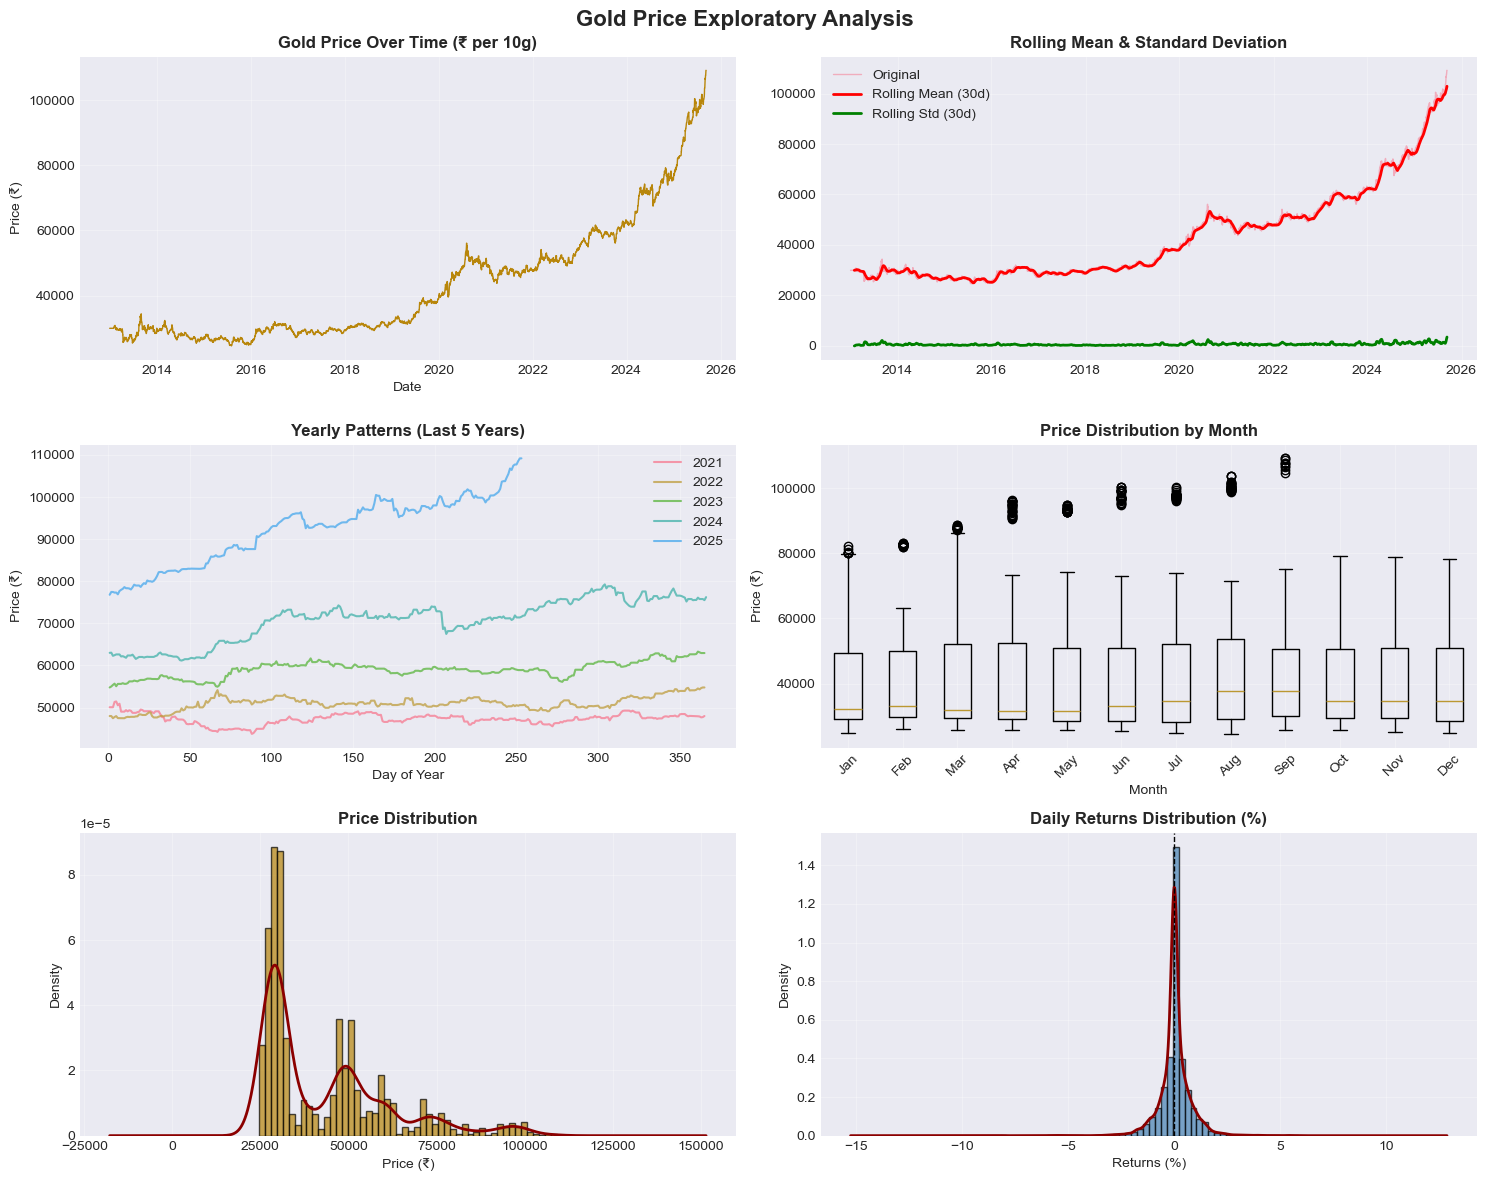

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Gold Price Exploratory Analysis', fontsize=16, fontweight='bold')
axes[0, 0].plot(df.index, df['Price'], linewidth=1, color='darkgoldenrod')
axes[0, 0].set_title('Gold Price Over Time (₹ per 10g)', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (₹)')
axes[0, 0].grid(True, alpha=0.3)
rolling_mean = df['Price'].rolling(window=30).mean()
rolling_std = df['Price'].rolling(window=30).std()

axes[0, 1].plot(df.index, df['Price'], label='Original', alpha=0.5, linewidth=1)
axes[0, 1].plot(df.index, rolling_mean, label='Rolling Mean (30d)', 
                color='red', linewidth=2)
axes[0, 1].plot(df.index, rolling_std, label='Rolling Std (30d)', 
                color='green', linewidth=2)
axes[0, 1].set_title('Rolling Mean & Standard Deviation', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Year-over-Year comparison
df['Year'] = df.index.year
df['DayOfYear'] = df.index.dayofyear

for year in df['Year'].unique()[-5:]:  # Last 5 years
    year_data = df[df['Year'] == year]
    axes[1, 0].plot(year_data['DayOfYear'], year_data['Price'], 
                    label=str(year), alpha=0.7)

axes[1, 0].set_title('Yearly Patterns (Last 5 Years)', fontweight='bold')
axes[1, 0].set_xlabel('Day of Year')
axes[1, 0].set_ylabel('Price (₹)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Monthly Boxplot
df['Month'] = df.index.month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_data = [df[df['Month'] == i]['Price'].values for i in range(1, 13)]
axes[1, 1].boxplot(monthly_data, labels=month_names)
axes[1, 1].set_title('Price Distribution by Month', fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Price (₹)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# 5. Distribution (Histogram + KDE)
axes[2, 0].hist(df['Price'], bins=50, density=True, alpha=0.7, 
                color='darkgoldenrod', edgecolor='black')
df['Price'].plot(kind='kde', ax=axes[2, 0], secondary_y=False, 
                 color='darkred', linewidth=2)
axes[2, 0].set_title('Price Distribution', fontweight='bold')
axes[2, 0].set_xlabel('Price (₹)')
axes[2, 0].set_ylabel('Density')
axes[2, 0].grid(True, alpha=0.3)

# 6. Daily Returns Distribution
  # Percentage returns
axes[2, 1].hist(df['Returns'].dropna(), bins=50, density=True, 
                alpha=0.7, color='steelblue', edgecolor='black')
df['Returns'].plot(kind='kde', ax=axes[2, 1], color='darkred', linewidth=2)
axes[2, 1].set_title('Daily Returns Distribution (%)', fontweight='bold')
axes[2, 1].set_xlabel('Returns (%)')
axes[2, 1].set_ylabel('Density')
axes[2, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
print(f"  Mean: ₹{df['Price'].mean():,.2f}")
print(f"  Median: ₹{df['Price'].median():,.2f}")
print(f"  Std Dev: ₹{df['Price'].std():,.2f}")
print(f"  Min: ₹{df['Price'].min():,.2f}")
print(f"  Max: ₹{df['Price'].max():,.2f}")
print(f"  Range: ₹{df['Price'].max() - df['Price'].min():,.2f}")

print(f"\nReturns Statistics:")
print(f"  Mean: {df['Returns'].mean():.4f}%")
print(f"  Std Dev: {df['Returns'].std():.4f}%")
print(f"  Skewness: {df['Returns'].skew():.4f}")
print(f"  Kurtosis: {df['Returns'].kurtosis():.4f}")

  Mean: ₹43,060.55
  Median: ₹32,896.50
  Std Dev: ₹18,225.40
  Min: ₹24,545.00
  Max: ₹109,197.00
  Range: ₹84,652.00

Returns Statistics:
  Mean: 0.0307%
  Std Dev: 0.7473%
  Skewness: -0.3529
  Kurtosis: 12.1284


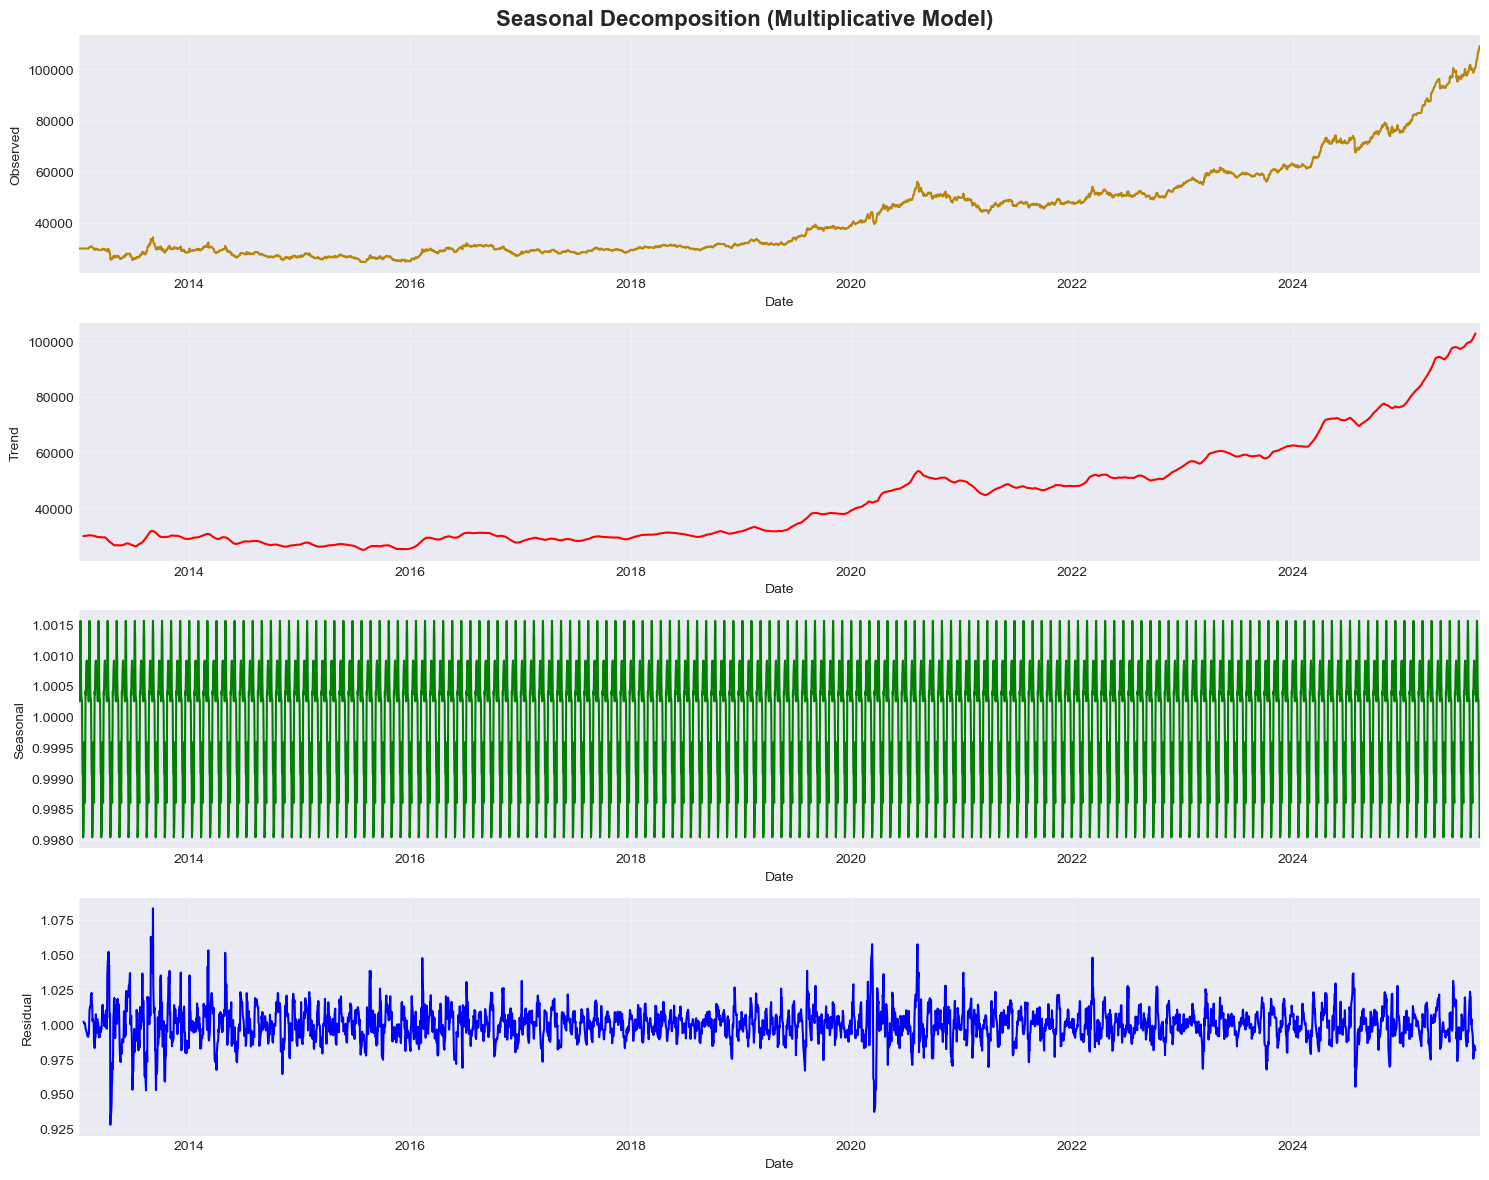

In [17]:
decomposition = seasonal_decompose(df['Price'], model='multiplicative', period=30)
# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Seasonal Decomposition (Multiplicative Model)', 
             fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], color='darkgoldenrod')
axes[0].set_ylabel('Observed')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='blue')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
seasonal_strength = 1 - (decomposition.resid.var() / 
                         (decomposition.resid + decomposition.seasonal).var())
trend_strength = 1 - (decomposition.resid.var() / 
                      (decomposition.resid + decomposition.trend).var())

In [19]:
seasonal_strength

0.006206594128011167

In [20]:
trend_strength

0.99999999999955

In [21]:
result=adfuller(df.Price)
print(f'p-value:{result[1]}')

if result[1]>0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

p-value:1.0
The time series is not stationary


In [22]:
df['Price_diff'] = df['Price'].diff()

In [23]:
result=adfuller(df.Price_diff.dropna())
print(f'p-value:{result[1]}')

if result[1]>0.05:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

p-value:7.343992025201508e-27
The time series is stationary


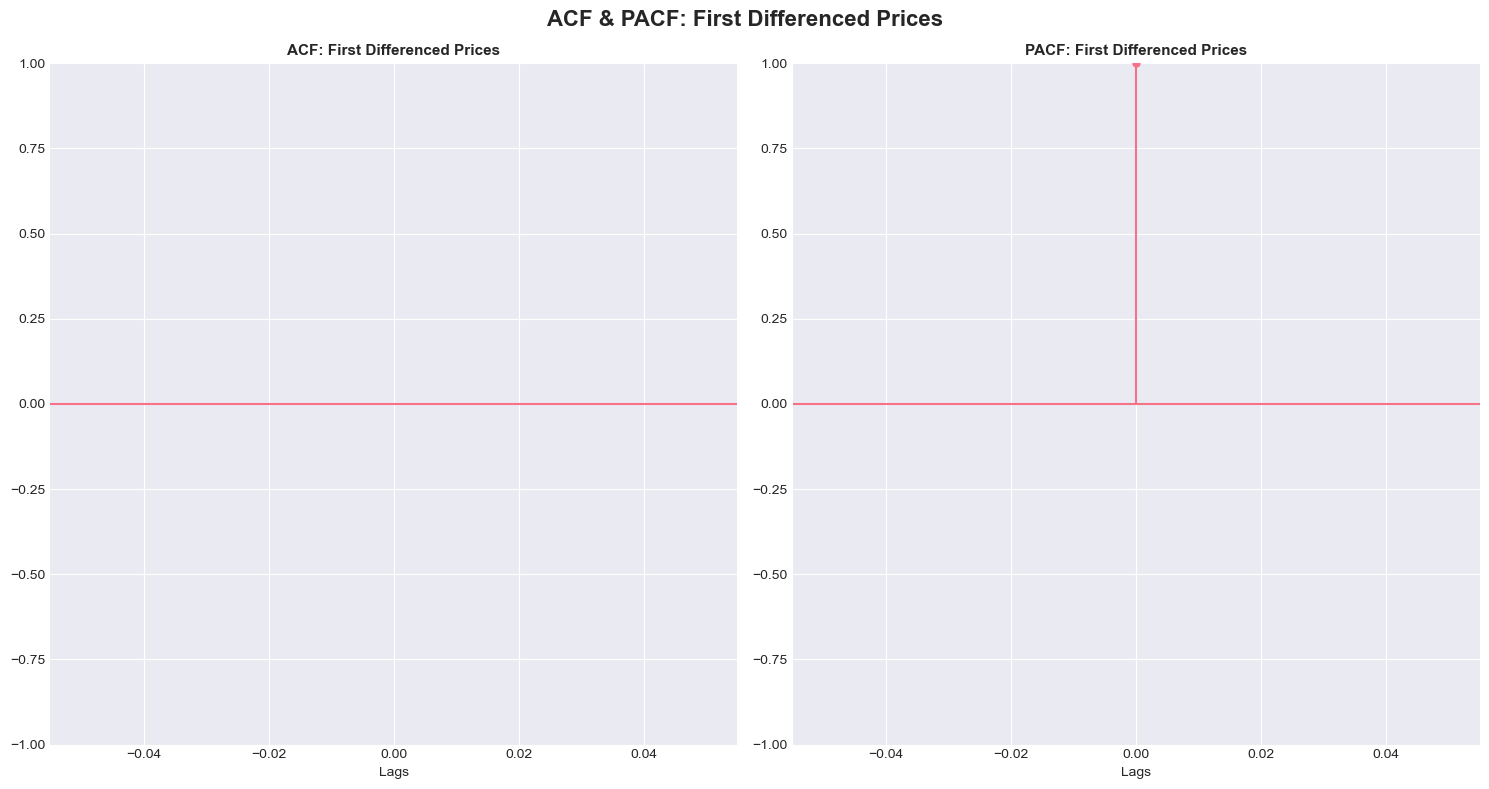

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

fig.suptitle(
    'ACF & PACF: First Differenced Prices',
    fontsize=16,
    fontweight='bold'
)

plot_acf(df['Price_diff'], lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: First Differenced Prices', fontweight='bold', fontsize=11)
axes[0].set_xlabel('Lags')

plot_pacf(df['Price_diff'], lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF: First Differenced Prices', fontweight='bold', fontsize=11)
axes[1].set_xlabel('Lags')

plt.tight_layout()
plt.show()


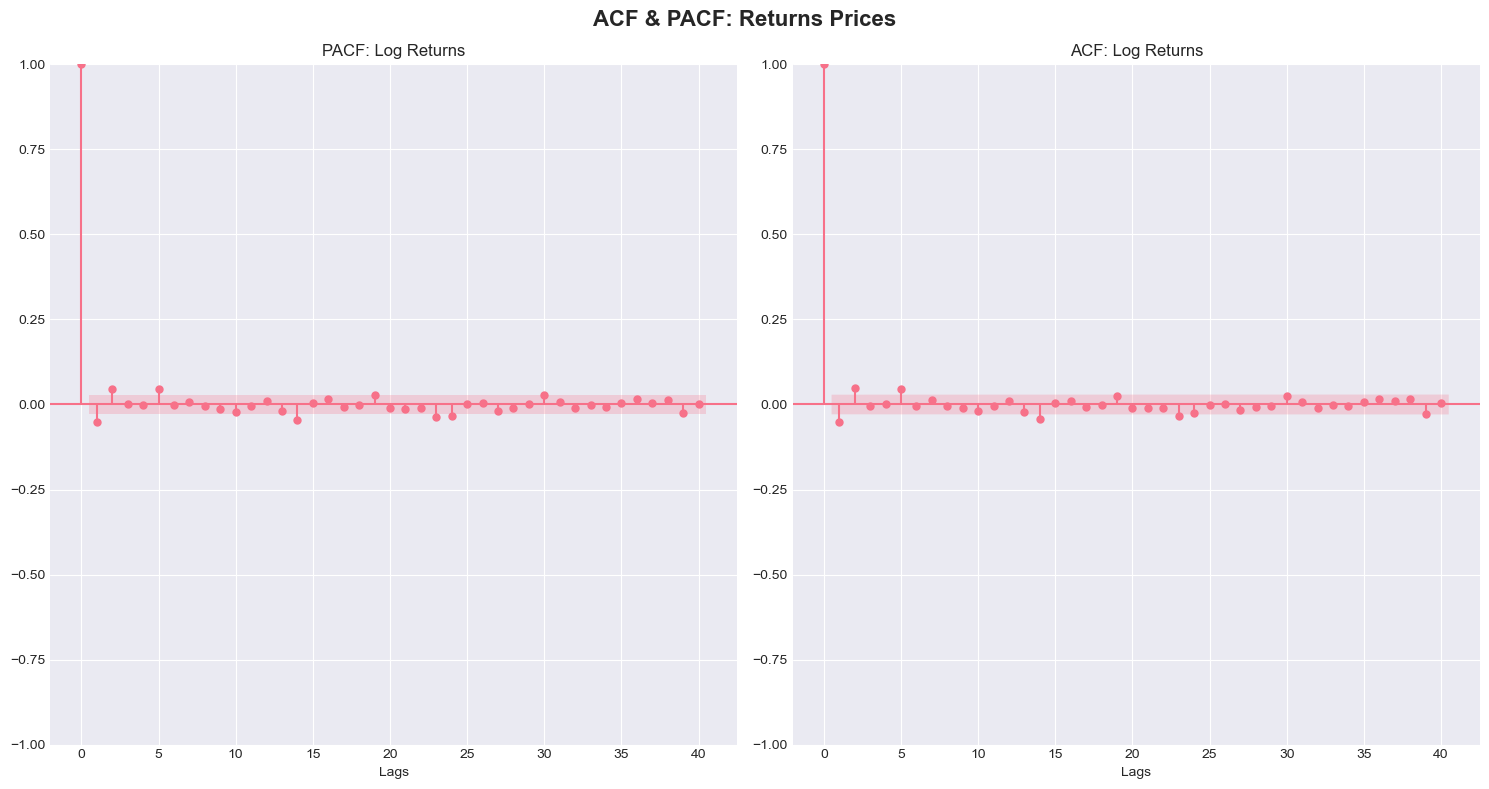

In [25]:
df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
df['Log_Returns'] = df['Log_Returns'].replace([np.inf, -np.inf], np.nan)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle(
    'ACF & PACF: Returns Prices',
    fontsize=16,
    fontweight='bold'
)
plot_pacf(df['Log_Returns'].dropna(), lags=40, ax=axes[0], alpha=0.05, method='ywm')
axes[0].set_title('PACF: Log Returns')
axes[0].set_xlabel('Lags')

plot_acf(df['Log_Returns'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('ACF: Log Returns')
axes[1].set_xlabel('Lags')

plt.tight_layout()
plt.show()


In [26]:
df['y'] = df['Price']

In [27]:
test_days = 30  
train = df.iloc[:-test_days].copy()
test = df.iloc[-test_days:].copy()

In [28]:
window = 7
ma_value = train['y'].rolling(window=window).mean().iloc[-1]
ma_forecast = pd.Series([ma_value] * len(test), index=test.index)

# Metrics
ma_rmse = mean_squared_error(test['y'], ma_forecast, squared=False)
ma_mae = mean_absolute_error(test['y'], ma_forecast)
ma_mape = mean_absolute_percentage_error(test['y'], ma_forecast) * 100

print(f"RMSE: {ma_rmse:.0f}")
print(f"MAE:  {ma_mae:.0f}")
print(f"MAPE: {ma_mape:.2f}%")


RMSE: 3844
MAE:  2943
MAPE: 2.79%


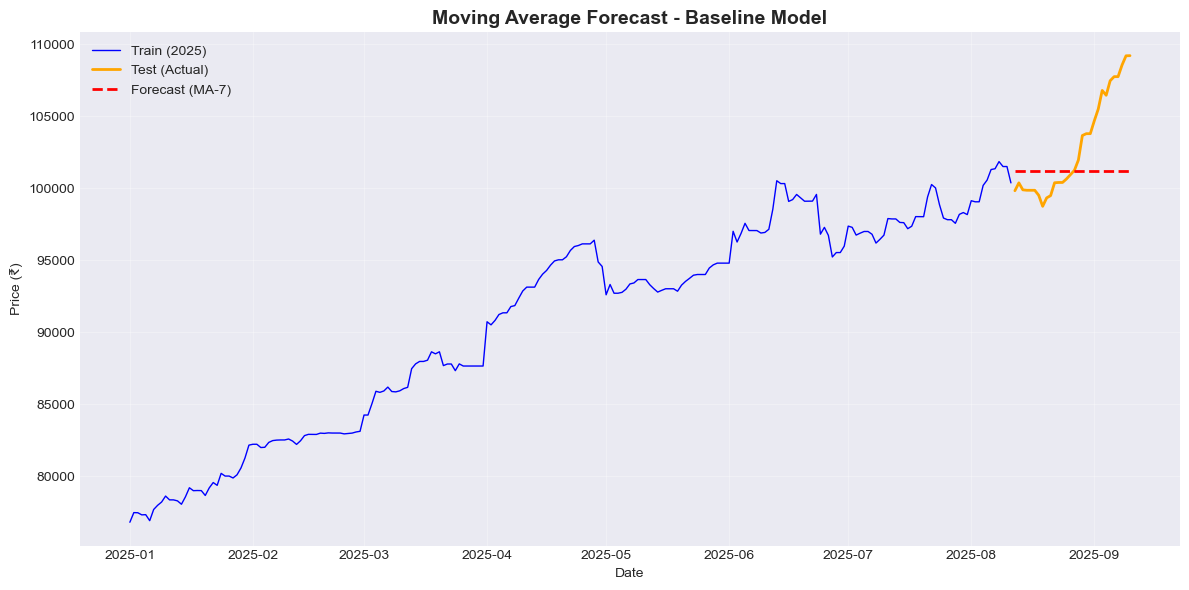

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['y'].loc['2025':], label='Train (2025)', color='blue', linewidth=1)
ax.plot(test['y'], label='Test (Actual)', color='orange', linewidth=2)
ax.plot(ma_forecast, label='Forecast (MA-7)', color='red', linestyle='--', linewidth=2)
ax.set_title('Moving Average Forecast - Baseline Model', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (₹)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
results = []
arima_specs = [
    (1, 1, 0, "AR(1) with differencing"),
    (0, 1, 1, "MA(1) with differencing"),
    (1, 1, 1, "ARMA(1,1) with differencing")
]

arima_forecasts = {}

for p, d, q, description in arima_specs:
    print(f"\n--- ARIMA({p},{d},{q}): {description} ---")
    
    # Fit SARIMAX (more robust than ARIMA)
    model = SARIMAX(train['y'], order=(p, d, q), seasonal_order=(0, 0, 0, 0))
    fitted = model.fit(disp=False)
    
    # Forecast
    forecast = fitted.forecast(steps=len(test))
    arima_forecasts[f'ARIMA({p},{d},{q})'] = forecast
    
    # Metrics
    rmse = mean_squared_error(test['y'], forecast, squared=False)
    mae = mean_absolute_error(test['y'], forecast)
    mape = mean_absolute_percentage_error(test['y'], forecast) * 100
    
    print(f"AIC: {fitted.aic:.2f}")
    print(f"RMSE: {rmse:.0f}")
    print(f"MAE:  {mae:.0f}")
    print(f"MAPE: {mape:.2f}%")
    
    results.append([f'ARIMA({p},{d},{q})', rmse, mae, mape])


--- ARIMA(1,1,0): AR(1) with differencing ---
AIC: 66374.64
RMSE: 4262
MAE:  2995
MAPE: 2.82%

--- ARIMA(0,1,1): MA(1) with differencing ---
AIC: 66375.00
RMSE: 4264
MAE:  2996
MAPE: 2.82%

--- ARIMA(1,1,1): ARMA(1,1) with differencing ---
AIC: 66369.69
RMSE: 4260
MAE:  2995
MAPE: 2.82%


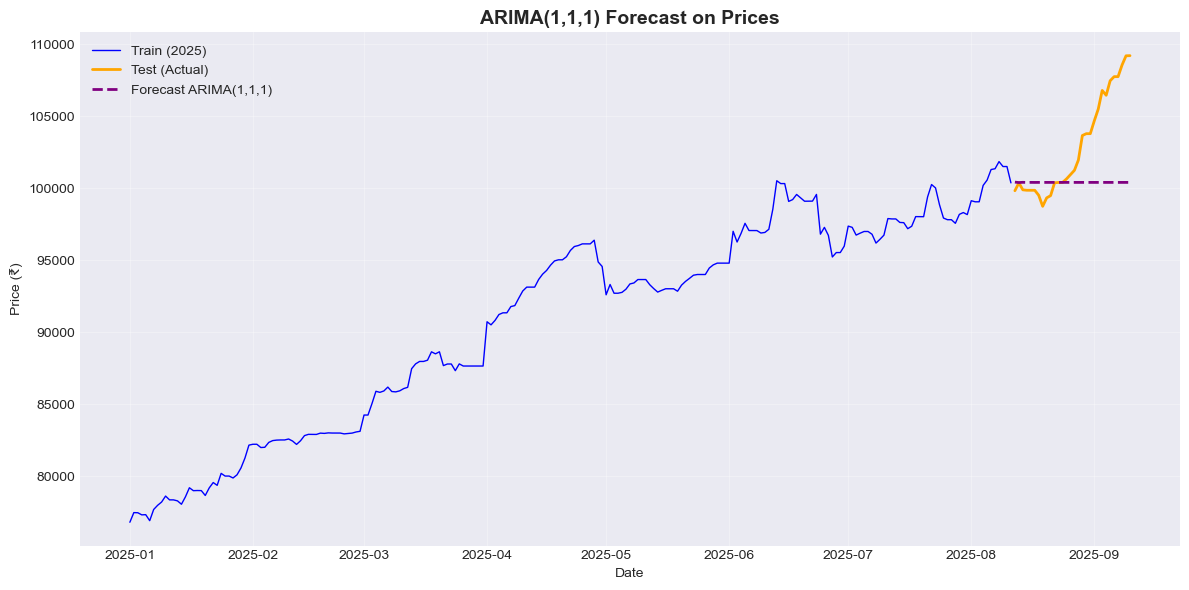

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['y'].loc['2025':], label='Train (2025)', color='blue', linewidth=1)
ax.plot(test['y'], label='Test (Actual)', color='orange', linewidth=2)
ax.plot(forecast, label=f'Forecast ARIMA({p},{d},{q})', 
            color='purple', linestyle='--', linewidth=2)
ax.set_title(f'ARIMA({p},{d},{q}) Forecast on Prices', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (₹)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
df

,Price,Returns,Year,DayOfYear,Month,Price_diff,Log_Returns,y
Date,,,,,,,,
2013-01-01,29951.0,NaN,2013,1,1,NaN,NaN,29951.0
2013-01-02,29951.0,0.000000,2013,2,1,0.0,0.000000,29951.0
2013-01-03,29951.0,0.000000,2013,3,1,0.0,0.000000,29951.0
2013-01-04,29951.0,0.000000,2013,4,1,0.0,0.000000,29951.0
2013-01-05,29951.0,0.000000,2013,5,1,0.0,0.000000,29951.0
...,...,...,...,...,...,...,...,...
2025-09-06,107740.0,0.266160,2025,249,9,286.0,0.002658,107740.0
2025-09-07,107740.0,0.000000,2025,250,9,0.0,0.000000,107740.0
2025-09-08,108548.0,0.749954,2025,251,9,808.0,0.007472,108548.0


In [33]:
train_returns = train['Log_Returns'].dropna()
print(f"Returns available: {len(train_returns)} observations")
print(f"Mean return: {train_returns.mean():.6f}")
print(f"Std return: {train_returns.std():.6f}")
returns = train_returns  

Returns available: 4605 observations
Mean return: 0.000263
Std return: 0.007493


In [34]:
result = adfuller(returns)
print(f"ADF test p-value: {result[1]:.2f}")
if result[1] < 0.05:
    print("Returns are stationary")
else:
    print("Returns are NOT stationary")

ADF test p-value: 0.00
Returns are stationary


In [35]:
arima_return_model = ARIMA(returns, order=(1, 0, 1))  # d=0 because returns are stationary
arima_return_fit = arima_return_model.fit()

print(f"ARIMA(1,0,1) on returns fitted")
print(f"AIC: {arima_return_fit.aic:.2f}")
print(f"\nARIMA Coefficients:")
print(arima_return_fit.summary().tables[1])

ARIMA(1,0,1) on returns fitted
AIC: -32014.47

ARIMA Coefficients:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.415      0.016    4.93e-05       0.000
ar.L1         -0.5540      0.136     -4.083      0.000      -0.820      -0.288
ma.L1          0.5037      0.141      3.564      0.000       0.227       0.781
sigma2      5.592e-05   4.51e-07    124.072      0.000     5.5e-05    5.68e-05


In [36]:
residuals = arima_return_fit.resid
print(f"\nResiduals: {len(residuals)} observations")
print(f"Mean residual: {residuals.mean():.6f} (should be ~0)")
print(f"Std residual: {residuals.std():.6f}")


Residuals: 4605 observations
Mean residual: 0.000001 (should be ~0)
Std residual: 0.007478


In [37]:
scaled_residuals = residuals * 100.0

In [38]:
garch_model = arch_model(
    scaled_residuals,
    mean='Zero',      # Mean already modeled by ARIMA
    vol='GARCH',      # GARCH(1,1)
    p=1,              # GARCH lag
    q=1,              # ARCH lag
    dist='t'          # Student-t distribution (fat tails)
)

garch_fit = garch_model.fit(disp='off')

In [39]:
print(garch_fit.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4035.39
Distribution:      Standardized Student's t   AIC:                           8078.78
Method:                  Maximum Likelihood   BIC:                           8104.52
                                              No. Observations:                 4605
Date:                      Mon, Jan 12 2026   Df Residuals:                     4605
Time:                              11:09:41   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0

In [40]:
omega = garch_fit.params['omega']
alpha = garch_fit.params['alpha[1]']
beta = garch_fit.params['beta[1]']
nu = garch_fit.params['nu']

In [41]:
print(f"ω (omega):  {omega:.8f}  <- Baseline variance")
print(f"α (alpha):  {alpha:.6f}  <- Reaction to shocks (news)")
print(f"β (beta):   {beta:.6f}  <- Persistence of volatility")
print(f"α + β:      {alpha + beta:.6f}  <- Total persistence")
print(f"ν (nu):     {nu:.2f}  <- Tail thickness (lower = fatter tails)")

if alpha + beta < 1:
    print("Model is stationary (α + β < 1)")
else:
    print("Model is non-stationary (α + β ≥ 1) - very persistent")

ω (omega):  0.01206500  <- Baseline variance
α (alpha):  0.031654  <- Reaction to shocks (news)
β (beta):   0.968346  <- Persistence of volatility
α + β:      1.000000  <- Total persistence
ν (nu):     2.30  <- Tail thickness (lower = fatter tails)
Model is stationary (α + β < 1)


In [42]:
arima_return_forecast = arima_return_fit.forecast(steps=len(test))

# Forecast volatility with GARCH
garch_forecast_obj = garch_fit.forecast(horizon=len(test), reindex=False)
variance_forecast = garch_forecast_obj.variance.values[-1] / (100.0**2)  # Scale back

print(f"Return forecasts: {len(arima_return_forecast)}")
print(f"Variance forecasts: {len(variance_forecast)}")

Return forecasts: 30
Variance forecasts: 30


In [43]:
# Step 4.5: Convert Returns to Prices
print("\n--- Step 5: Convert to Price Forecasts ---")

last_train_price = train['y'].iloc[-1]
print(f"Last training price: ₹{last_train_price:,.2f}")

# Cumulative returns approach
cum_log_returns = arima_return_forecast.cumsum()
price_forecast = last_train_price * np.exp(cum_log_returns)

# Calculate confidence intervals using GARCH volatility
std_forecast = np.sqrt(variance_forecast)
lower_prices = []
upper_prices = []

current_price = last_train_price
for i, ret in enumerate(arima_return_forecast):
    # 95% confidence interval: ±1.96 standard deviations
    lower_ret = ret - 1.96 * std_forecast[i]
    upper_ret = ret + 1.96 * std_forecast[i]
    
    lower_price = current_price * np.exp(lower_ret)
    upper_price = current_price * np.exp(upper_ret)
    
    lower_prices.append(lower_price)
    upper_prices.append(upper_price)
    
    current_price = current_price * np.exp(ret)  # Update for next day

price_forecast = pd.Series(price_forecast.values, index=test.index)
lower_bound = pd.Series(lower_prices, index=test.index)
upper_bound = pd.Series(upper_prices, index=test.index)


--- Step 5: Convert to Price Forecasts ---
Last training price: ₹100,363.00


In [44]:
garch_rmse = mean_squared_error(test['y'], price_forecast, squared=False)
garch_mae = mean_absolute_error(test['y'], price_forecast)
garch_mape = mean_absolute_percentage_error(test['y'], price_forecast) * 100

In [45]:
print(f"RMSE: {garch_rmse:.0f}")
print(f"MAE:  {garch_mae:.0f}")
print(f"MAPE: {garch_mape:.2f}%")

results.append(['ARIMA(1,0,1) + GARCH(1,1)', garch_rmse, garch_mae, garch_mape])

RMSE: 3849
MAE:  2754
MAPE: 2.60%


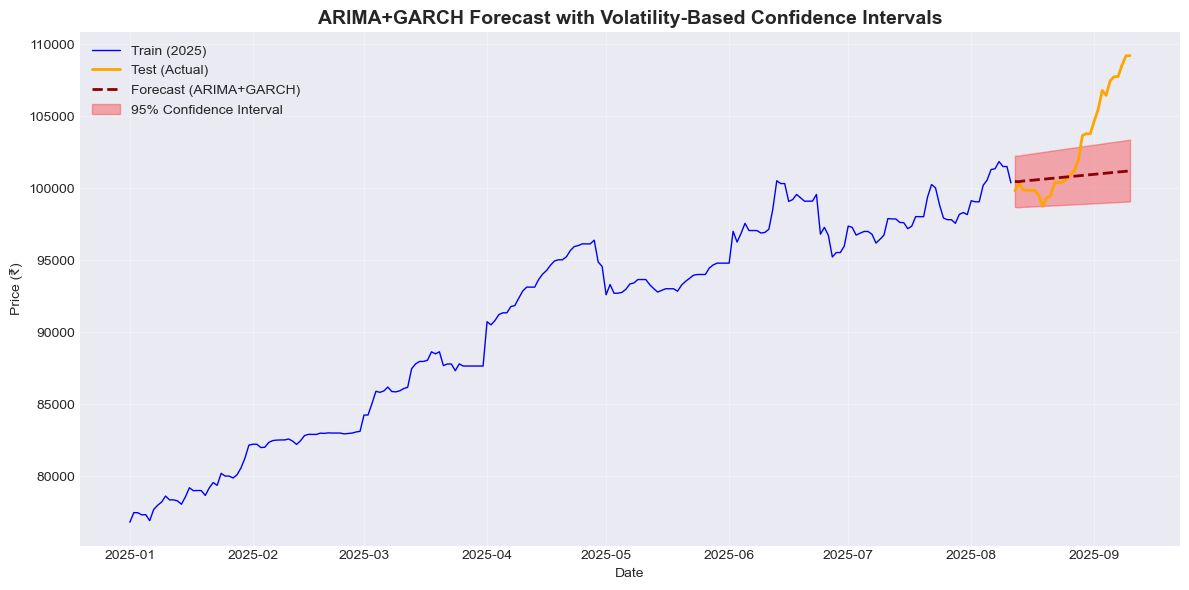

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train['y'].loc['2025':], label='Train (2025)', color='blue', linewidth=1)
ax.plot(test['y'], label='Test (Actual)', color='orange', linewidth=2)
ax.plot(price_forecast, label='Forecast (ARIMA+GARCH)', 
        color='darkred', linestyle='--', linewidth=2)
ax.fill_between(test.index, lower_bound, upper_bound,
                alpha=0.3, color='red', label='95% Confidence Interval')
ax.set_title('ARIMA+GARCH Forecast with Volatility-Based Confidence Intervals', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (₹)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [47]:
df

,Price,Returns,Year,DayOfYear,Month,Price_diff,Log_Returns,y
Date,,,,,,,,
2013-01-01,29951.0,NaN,2013,1,1,NaN,NaN,29951.0
2013-01-02,29951.0,0.000000,2013,2,1,0.0,0.000000,29951.0
2013-01-03,29951.0,0.000000,2013,3,1,0.0,0.000000,29951.0
2013-01-04,29951.0,0.000000,2013,4,1,0.0,0.000000,29951.0
2013-01-05,29951.0,0.000000,2013,5,1,0.0,0.000000,29951.0
...,...,...,...,...,...,...,...,...
2025-09-06,107740.0,0.266160,2025,249,9,286.0,0.002658,107740.0
2025-09-07,107740.0,0.000000,2025,250,9,0.0,0.000000,107740.0
2025-09-08,108548.0,0.749954,2025,251,9,808.0,0.007472,108548.0


In [48]:
#Forecast 30 days ahead
arima_forecast_train = arima_return_fit.forecast(steps=len(test))
garch_forecast_train = garch_fit.forecast(horizon=len(test), reindex=False)
var_forecast_train = garch_forecast_train.variance.values[-1] / (100.0**2)

In [49]:
alpha_train = garch_fit.params['alpha[1]']
beta_train = garch_fit.params['beta[1]']
print(f"α = {alpha_train:.2f}")
print(f"β = {beta_train:.2f}")
print(f"α + β = {alpha_train + beta_train:.2f}")

α = 0.03
β = 0.97
α + β = 1.00


In [50]:
arima_forecast_train = arima_return_fit.forecast(steps=len(test))
garch_forecast_train = garch_fit.forecast(horizon=len(test), reindex=False)
var_forecast_train = garch_forecast_train.variance.values[-1] / (100.0**2)

In [51]:
last_train_price = train['y'].iloc[-1]
cum_returns = arima_forecast_train.cumsum()  # Cumulative returns
backtest_forecast = last_train_price * np.exp(cum_returns)  # No /100 needed
backtest_forecast = pd.Series(backtest_forecast.values, index=test.index)

In [52]:
std_forecast = np.sqrt(var_forecast_train)  # Standard deviation in percentage points
lower_bound = []
upper_bound = []
current_price = last_train_price

for i, ret in enumerate(arima_forecast_train):  # Returns not scaled
    lower_ret = ret - 1.96 * std_forecast[i] / 100  # Convert std to return scale
    upper_ret = ret + 1.96 * std_forecast[i] / 100
    lower_bound.append(current_price * np.exp(lower_ret))
    upper_bound.append(current_price * np.exp(upper_ret))
    current_price = current_price * np.exp(ret)

lower_bound = pd.Series(lower_bound, index=test.index)
upper_bound = pd.Series(upper_bound, index=test.index)

In [53]:
rmse = mean_squared_error(test['y'], backtest_forecast, squared=False)
mae = mean_absolute_error(test['y'], backtest_forecast)
mape = mean_absolute_percentage_error(test['y'], backtest_forecast) * 100

In [54]:
print(f"RMSE: {rmse:.0f}")
print(f"MAE:  {mae:.0f}")
print(f"MAPE: {mape:.2f}%")
print(f"\nConclusion: Model validated with {mape:.2f}% average error")

RMSE: 3849
MAE:  2754
MAPE: 2.60%

Conclusion: Model validated with 2.60% average error


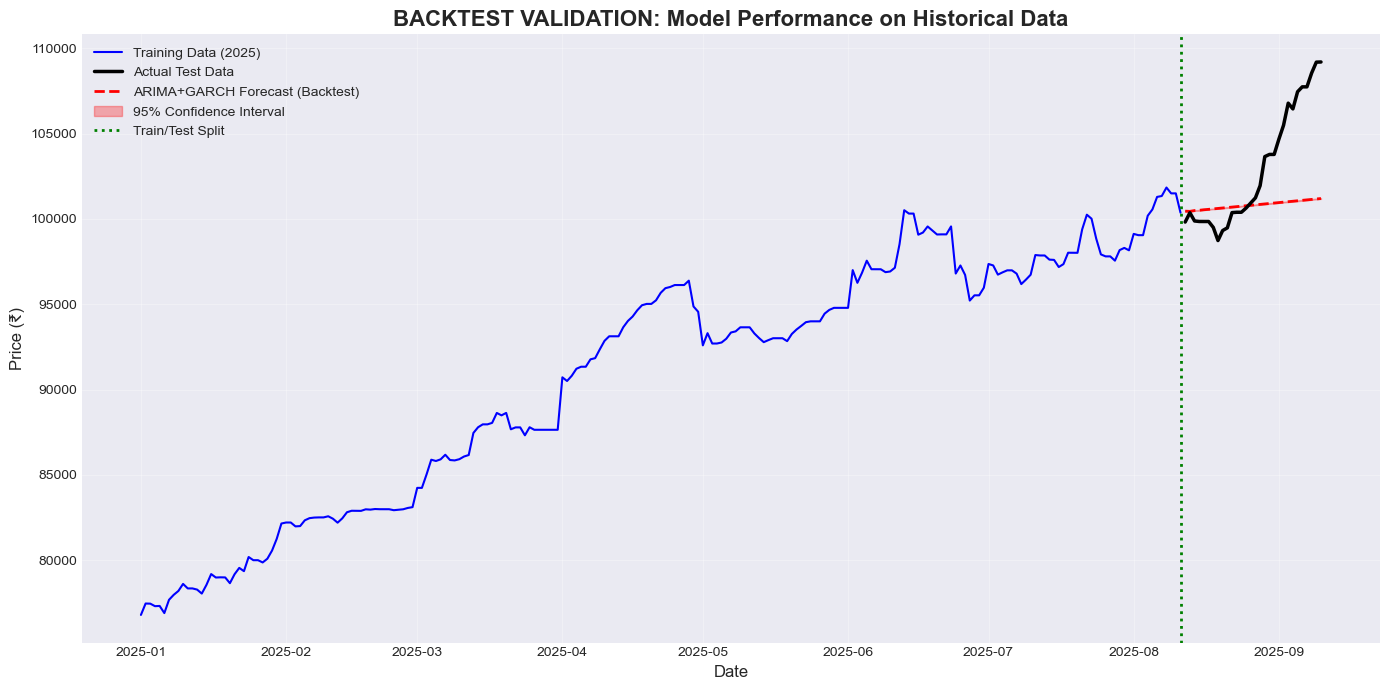

In [55]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(train['y'].loc['2025':], label='Training Data (2025)', 
        color='blue', linewidth=1.5)
ax.plot(test['y'], label='Actual Test Data', 
        color='black', linewidth=2.5, zorder=5)
ax.plot(backtest_forecast, label='ARIMA+GARCH Forecast (Backtest)', 
        color='red', linestyle='--', linewidth=2)
ax.fill_between(test.index, lower_bound, upper_bound, 
                alpha=0.3, color='red', label='95% Confidence Interval')
ax.axvline(train.index[-1], color='green', linestyle=':', linewidth=2, 
           label='Train/Test Split')
ax.set_title('BACKTEST VALIDATION: Model Performance on Historical Data', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (₹)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [56]:
all_returns = df['Log_Returns'].dropna()

print(f"\nProduction Forecast Setup:")
print(f"  Training: ALL {len(all_returns)} days of available data")
print(f"  Last known date: {df.index[-1]}")
print(f"  Last known price: {df['y'].iloc[-1]:,.2f}")


Production Forecast Setup:
  Training: ALL 4635 days of available data
  Last known date: 2025-09-10 00:00:00
  Last known price: 109,197.00


In [57]:
arima_model_full = ARIMA(all_returns, order=(1, 0, 1))
arima_fit_full = arima_model_full.fit()

In [58]:
residuals_full = arima_fit_full.resid * 100.0  # Scale to percentage
garch_model_full = arch_model(residuals_full, mean='Zero', vol='GARCH', 
                               p=1, q=1, dist='t')
garch_fit_full = garch_model_full.fit(disp='off')

In [59]:
omega_full = garch_fit_full.params['omega']
alpha_full = garch_fit_full.params['alpha[1]']
beta_full = garch_fit_full.params['beta[1]']
nu_full = garch_fit_full.params['nu']

print(f"ω (omega): {omega_full:.8f}")
print(f"α (alpha): {alpha_full:.6f}  <- {alpha_full*100:.1f}% from shocks")
print(f"β (beta):  {beta_full:.6f}  <- {beta_full*100:.1f}% persistence")
print(f"α + β:     {alpha_full + beta_full:.6f}")
print(f"ν (nu):    {nu_full:.2f}  <- Tail thickness")

ω (omega): 0.01202944
α (alpha): 0.031450  <- 3.1% from shocks
β (beta):  0.968550  <- 96.9% persistence
α + β:     1.000000
ν (nu):    2.30  <- Tail thickness


In [60]:

if alpha_full + beta_full >= 0.999:
    print("IGARCH detected: Volatility shocks are nearly permanent")
    print("Gold is in a persistent high-volatility regime")
else:
    half_life = np.log(0.5) / np.log(alpha_full + beta_full)
    print(f"Volatility half-life: {half_life:.1f} days")

IGARCH detected: Volatility shocks are nearly permanent
Gold is in a persistent high-volatility regime


In [61]:
forecast_horizon = 30
arima_forecast_future = arima_fit_full.forecast(steps=forecast_horizon)
garch_forecast_future = garch_fit_full.forecast(horizon=forecast_horizon, reindex=False)
var_forecast_future = garch_forecast_future.variance.values[-1] / (100.0**2)

In [62]:
last_known_price = df['y'].iloc[-1]
cum_returns_future = arima_forecast_future.cumsum()
future_prices = last_known_price * np.exp(cum_returns_future)

In [63]:
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), 
                              periods=forecast_horizon, freq='D')
future_forecast = pd.Series(future_prices.values, index=future_dates)

In [64]:
std_forecast_future = np.sqrt(var_forecast_future)  # In percentage points
lower_bound_future = []
upper_bound_future = []
current_price_future = last_known_price

for i, ret in enumerate(arima_forecast_future):  # Returns not scaled
    lower_ret = ret - 1.96 * std_forecast_future[i] / 100  # Convert to return scale
    upper_ret = ret + 1.96 * std_forecast_future[i] / 100
    lower_bound_future.append(current_price_future * np.exp(lower_ret))
    upper_bound_future.append(current_price_future * np.exp(upper_ret))
    current_price_future = current_price_future * np.exp(ret)

lower_bound_future = pd.Series(lower_bound_future, index=future_dates)
upper_bound_future = pd.Series(upper_bound_future, index=future_dates)

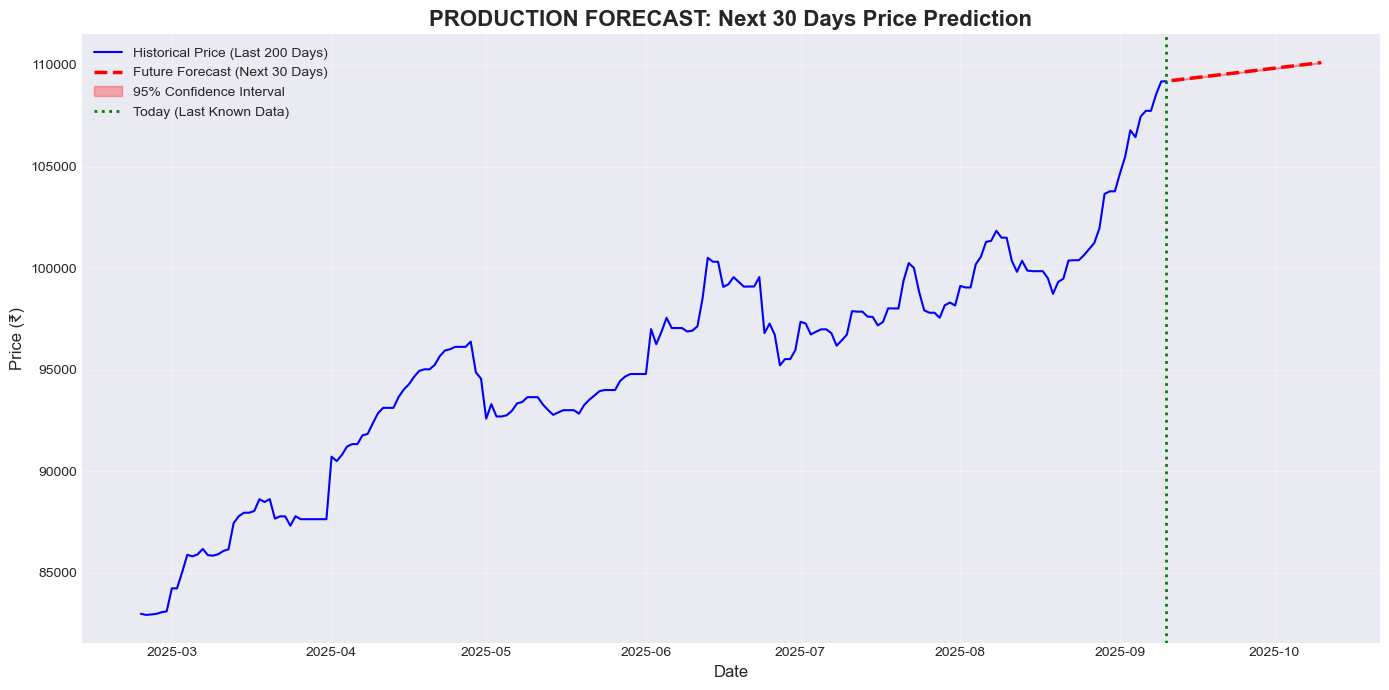

In [65]:
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data (last 200 days)
ax.plot(df['y'][-200:], label='Historical Price (Last 200 Days)', 
        color='blue', linewidth=1.5)

# Future forecast
ax.plot(future_forecast, label='Future Forecast (Next 30 Days)', 
        color='red', linestyle='--', linewidth=2.5)
ax.fill_between(future_dates, lower_bound_future, upper_bound_future, 
                alpha=0.3, color='red', label='95% Confidence Interval')

# Mark the transition
ax.axvline(df.index[-1], color='green', linestyle=':', linewidth=2, 
           label='Today (Last Known Data)')

ax.set_title('PRODUCTION FORECAST: Next 30 Days Price Prediction', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (₹)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [66]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_prices.values,
    'Lower_95_CI': lower_bound_future.values,
    'Upper_95_CI': upper_bound_future.values,
    'Expected_Return_log': arima_forecast_future.values,
    'Volatility_pct_points': std_forecast_future
})

print(forecast_df.head(10).to_string(index=False))

      Date  Predicted_Price   Lower_95_CI   Upper_95_CI  Expected_Return_log  Volatility_pct_points
2025-09-11    109234.862350 109215.882725 109253.845273             0.000347               0.008866
2025-09-12    109261.124677 109241.995777 109280.256927             0.000240               0.008933
2025-09-13    109293.696615 109274.418344 109312.978288             0.000298               0.009000
2025-09-14    109322.856683 109303.430625 109342.286194             0.000267               0.009067
2025-09-15    109353.881751 109334.308536 109373.458470             0.000284               0.009133
2025-09-16    109383.907503 109364.188250 109403.630313             0.000275               0.009199
2025-09-17    109414.488711 109394.624237 109434.356792             0.000280               0.009264
2025-09-18    109444.781438 109424.772696 109464.793839             0.000277               0.009328
2025-09-19    109475.243782 109455.091618 109495.399655             0.000278               0.009393


In [73]:
train_price = train['Price']
test_price = test['Price']
model_holt = ExponentialSmoothing(
    train_price,
    trend="mul",          # multiplicative trend
    seasonal=None         # no seasonality
)

# Fit model
holt_fit = model_holt.fit()

# Forecast same length as test
holt_forecast = holt_fit.forecast(steps=len(test_price))

# ---------- Metrics ----------
holt_rmse = mean_squared_error(test_price, holt_forecast, squared=False)
holt_mae = mean_absolute_error(test_price, holt_forecast)
holt_mape = mean_absolute_percentage_error(test_price, holt_forecast) * 100

print(f"   RMSE: ₹{holt_rmse:,.0f} | MAE: ₹{holt_mae:,.0f} | MAPE: {holt_mape:.2f}%")

results.append(['Holt-Winters (mul trend)', holt_rmse, holt_mae, holt_mape])



   RMSE: ₹4,076 | MAE: ₹2,882 | MAPE: 2.72%


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


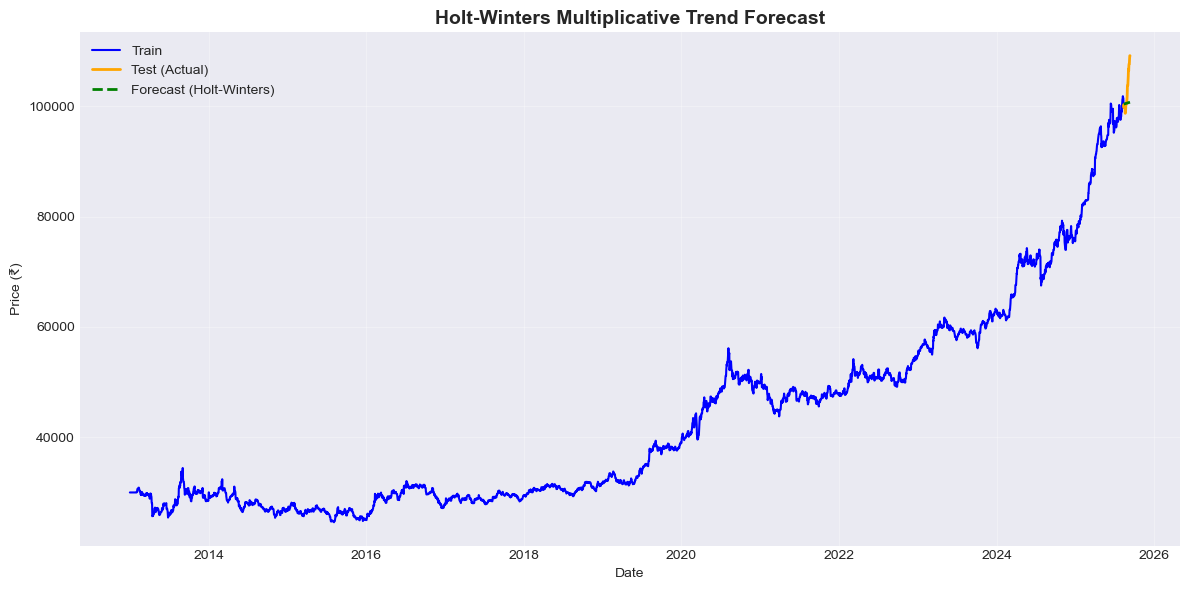

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train.index, train_price, label="Train", color="blue")
ax.plot(test.index, test_price, label="Test (Actual)", color="orange", linewidth=2)
ax.plot(test.index, holt_forecast, label="Forecast (Holt-Winters)",
        color="green", linestyle="--", linewidth=2)

ax.set_title("Holt-Winters Multiplicative Trend Forecast", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Price (₹)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()